In [1]:
#Package Imports
import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import datetime

#tensorflow inputs
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

env_name = "CartPole-v1"

Using TensorFlow backend.


In [6]:
#Setup Policy NN

class AC_solver:
    
    def __init__(self, observation_space, action_space, log_dir):
        
        #Solver parameters
        self.learning_rate = 0.001
        self.gamma = 0.99
        self.action_space = action_space
        
        #writer for tensorboard
        self.summary_writer = tf.summary.create_file_writer(log_dir)
        
        #Policy
        #NN parameters
        #1 hidden layer NN      
        self.model = Sequential()
        self.model.name = "Actor"
        self.model.add(Dense(24, input_shape=(observation_space,), activation="relu", name="input"))
        self.model.add(Dense(24, activation="relu", name="hidden"))
        self.model.add(Dense(self.action_space, activation="softmax", name="output"))
        self.model.compile(loss="mse", optimizer=Adam(lr=self.learning_rate))
        print(self.model.summary())
        
        #Value Function Baseline
        #1 hidden layer NN
        self.V = Sequential()
        self.V.name = "Critic"
        self.V.add(Dense(24, input_shape=(observation_space,), activation="relu", name="input"))
        self.V.add(Dense(24, activation="relu", name="hidden"))
        self.V.add(Dense(1, activation="linear", name="output"))
        self.V.compile(loss="mse", optimizer=Adam(lr=self.learning_rate))
        print(self.V.summary())
        
    def act(self, state):
        #compute the action probabilities from the model
        probs = (self.model.predict(state)).squeeze()
        #compute an action from the probabilities
        action = np.random.choice(self.action_space, p = probs)
        #compute the log of the probability of the chosen action
        log_prob = np.log(probs[action])
        return action, log_prob
    
    def act_validation(self, state):
        #take the action with the highest probability
        probs = (self.model.predict(state)).squeeze()
        action = np.argmax(probs)
        return action
        
    def update_policy(self, log_probs, rewards, states, actions):
        
        #compute discounted rewards:
        disc_rewards = []
        
        for i in range(0, len(rewards)):
            R_t = 0
            exponent = 0
            for r in rewards[i:]:
                R_t += self.gamma **  exponent * r
                exponent += 1
            disc_rewards.append(R_t)
            
        disc_rewards = np.asarray(disc_rewards)
        
        #update critic:
        self.V.train_on_batch(np.asarray(states).squeeze(), disc_rewards)
        
        #compute the advantage
        #predict rewards based on states
        V_predict = []
        for i in range(0,len(states)):
            V_predict.append( (self.V.predict(states[i])).squeeze() )
        
        #compute the advantage
        advantage = np.zeros(len(states))
        #target = r(s,a) + gamma * V(s_prime)
        for i in range(0, len(states)-1):
            advantage[i] = disc_rewards[i] + self.gamma * V_predict[i+1] - V_predict[i]
        #last state has no associated s_prime, so set V(s_prime) = 0
        advantage[len(states)-1] = disc_rewards[len(states)-1] - V_predict[len(states)-1]
        
        #compute the loss function
        policy_grad = np.multiply(-np.asarray(log_probs), advantage)
          
        #update the actor(policy) network:
        target = np.zeros((len(states), self.action_space))
                
        for i in range(0, len(states)):
            target[i][actions[i]] = policy_grad[i]
        loss = self.model.train_on_batch(np.asarray(states).squeeze(), target)
        return loss
    
    def log_results(self, name, val, idx):
    #log results for visualization in Tensorboard
        with self.summary_writer.as_default():
            tf.summary.scalar(name, val, step=idx)
            self.summary_writer.flush()

In [4]:
#Plot functions:
def plot_results(results, mean_results, episode, num_ticks_to_win):
    plt.clf()
    plt.plot(results,'b', label = "score")
    plt.plot(mean_results,'r',label="mean score")
    tick_plot = np.arange(0,episode)
    plt.plot(tick_plot, np.ones(np.shape(tick_plot)) * num_ticks_to_win,'k-', label="win threshold")
    plt.xlabel('Episode Number')
    plt.ylabel('Episode Score')
    plt.title('Cartpole scores')
    plt.legend()
    plt.show()

In [13]:
#Solve cartpole
    
#problem solved condition
num_ticks_to_win = 195

scores = deque(maxlen=100)
score_list = []
mean_score_list = []
num_trials = -1

losses = []

verbose = True

#max number of episodes
max_episodes = 10000

#training environment - exploration policy
env = gym.make(env_name)
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

#validation environment - greedy policy
env_validation = gym.make(env_name)

#directory for logfiles (tensorboard)
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

ac_solver = AC_solver(observation_space, action_space, log_dir)

for episode in range(0, max_episodes):
    states = []
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    states.append(state)
    
    actions = []
    
    log_probs = []
    rewards = []
    
    done = False
    step = 0
    while not done:
        #rollout with present policy
        step += 1
        #compute the action for the present state
        action, log_prob = ac_solver.act(state)
        actions.append(action)
        log_probs.append(log_prob)
        
        #advance the environment
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, observation_space])
        states.append(next_state)
        rewards.append(reward)
        
        state = next_state
    states.pop()
    
    #Validation Policy
    state = env_validation.reset()
    state = np.reshape(state, [1, observation_space])
    done_validation = False
    step = 0
    while not done_validation:
        step += 1
        #compute the greedy action for the present state
        action = ac_solver.act_validation(state)
        
        #advance the environment
        next_state, reward, done_validation, info = env_validation.step(action)
        next_state = np.reshape(next_state, [1, observation_space])
        state = next_state
    
    #number of steps the pole was upright
    scores.append(step)
    ac_solver.log_results('scores', step, episode)
    score_list.append(step)

    mean_score = np.mean(scores)
    ac_solver.log_results('mean_score(100)', mean_score, episode)

    #score_list.append(step)
    mean_score_list.append(mean_score)

    if mean_score >= num_ticks_to_win and episode >= 100:
        if verbose:
            print('Ran {} episodes. Solved after {} trials'.format(episode, episode - 100))
        num_trials = episode - 100
        break
        
    if verbose and episode % 100 == 0:
        print('[Episode {}] - Mean survival time over last 100 episodes was {}.'.format(episode, mean_score))
    
    loss = ac_solver.update_policy(log_probs, rewards, states, actions)
    losses.append(loss)
    
print("Program Complete")

Model: "Actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 24)                120       
_________________________________________________________________
hidden (Dense)               (None, 24)                600       
_________________________________________________________________
output (Dense)               (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
None
Model: "Critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 24)                120       
_________________________________________________________________
hidden (Dense)               (None, 24)                600       
__________________________________________

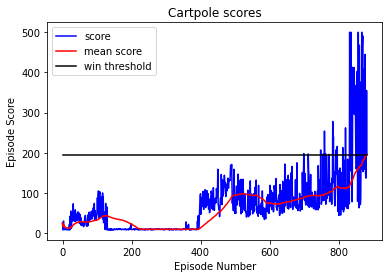

In [14]:
plot_results(score_list, mean_score_list, episode, num_ticks_to_win)